### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 6
### Due: Saturday, Mar 14th at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

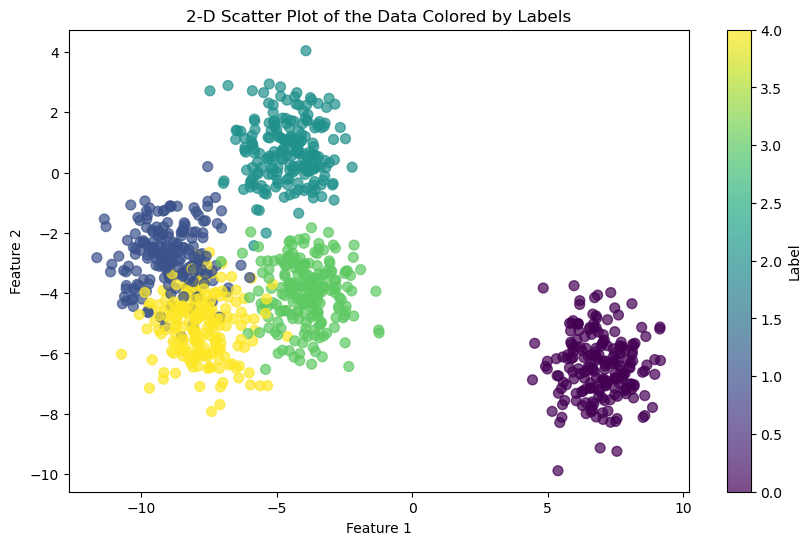

In [7]:
# Part 1
import numpy as np
import matplotlib.pyplot as plt

data = np.load('./hw_data/hw6_data_1.npy')

x = data[:, :-1]
y = data[:, -1]

plt.figure(figsize=(10, 6))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.title('2-D Scatter Plot of the Data Colored by Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Label')
plt.show()


Best bandwidth: 0.4724


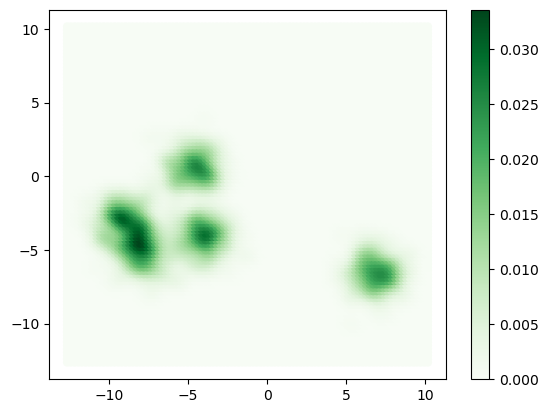

In [14]:
# Part 2
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bandwidths = np.linspace(0.1, 1.0, 30)
grid = GridSearchCV(
    KernelDensity(kernel='gaussian'),
    {'bandwidth': bandwidths},
    cv=5
)
grid.fit(X)

best_bandwidth = grid.best_params_['bandwidth']
print(f"Best bandwidth: {best_bandwidth:.4f}")

kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
kde.fit(X)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
u = v = np.linspace(x_min, x_max, 100)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid))

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Greens", edgecolor="None")
plt.colorbar()
plt.show()

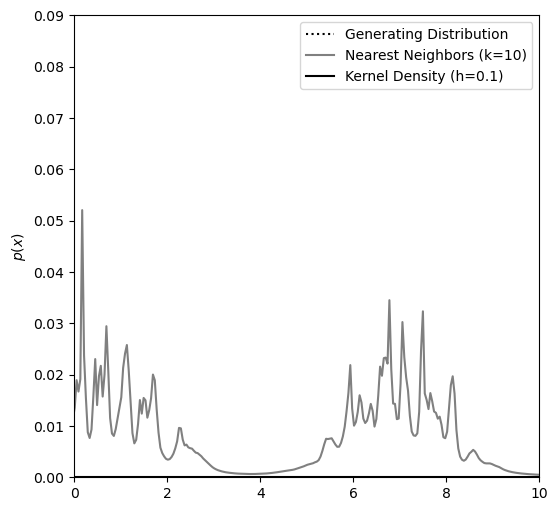

In [44]:
# Part 3
from scipy import stats
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x) 
                          for (mu, gamma, f) in data])

fig = plt.figure(figsize=(6, 6))

N = 5000
k = 10 
xN = x[:N]
xN_2d = xN.reshape(-1, 1)
t = np.linspace(-10, 30, 1000)
t_2d = np.zeros((len(t), X.shape[1]))
t_2d[:, 0] = t 

kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(X)
dens_kde = np.exp(kde.score_samples(t_2d))

nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(xN_2d)
dens_nbrs = nbrs.eval(t[:, None]) / N 

plt.plot(t, true_pdf(t), ':', color='black', 
         zorder=3, label="Generating Distribution")
plt.plot(xN, -0.005 * np.ones(len(xN)), '|k')
plt.plot(t, dens_nbrs, '-', lw=1.5, color='gray', 
         zorder=2, label="Nearest Neighbors (k=%i)" % k)
plt.plot(t, dens_kde, '-', color='black', 
         zorder=3, label="Kernel Density (h=0.1)")

plt.ylabel('$p(x)$')
plt.legend(loc='upper right')
plt.xlim(0, 10)
plt.ylim(0, 0.09)
plt.show()

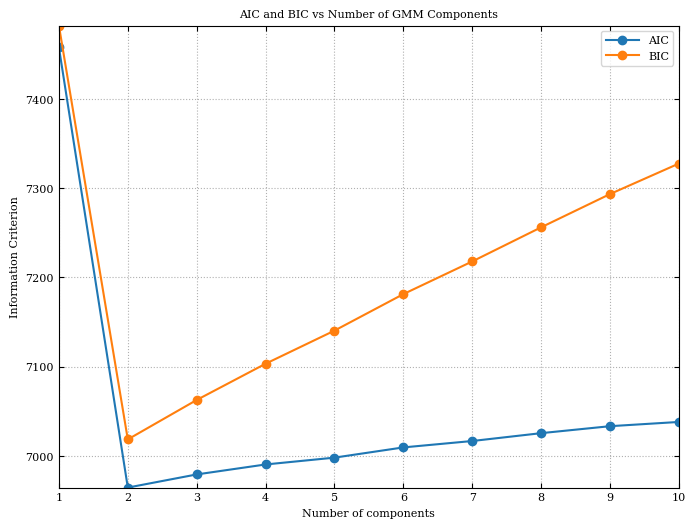

Optimal number of components according to BIC: 2


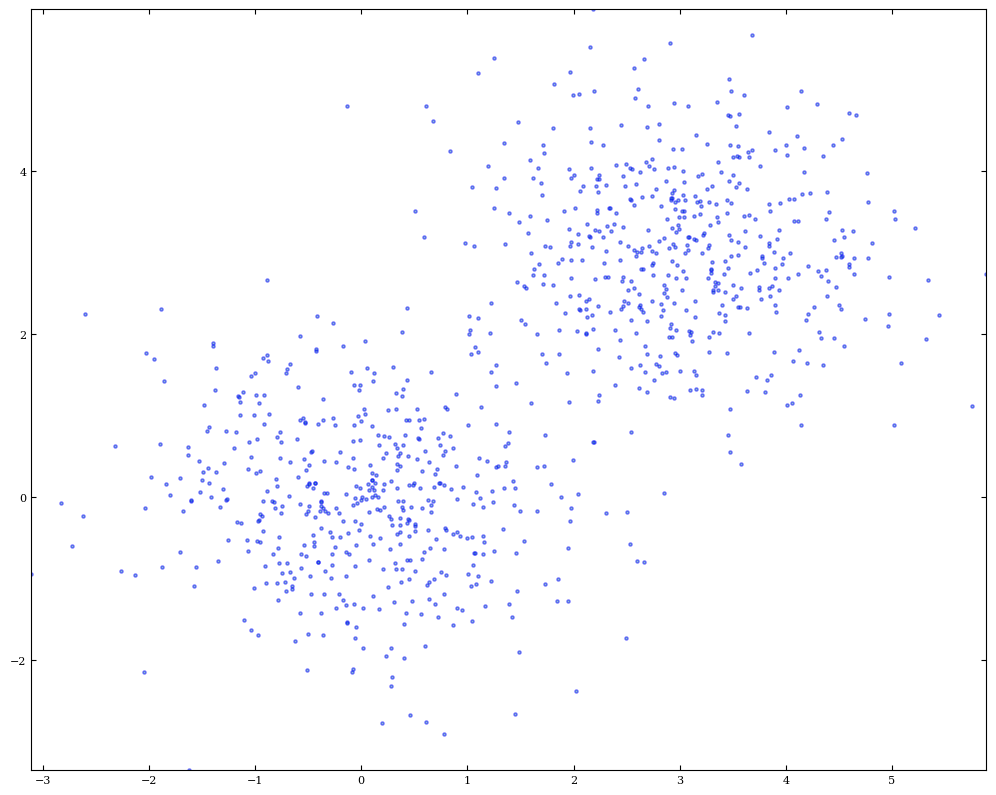

Optimal number of components according to BIC: 2


In [48]:
# Part 4
from sklearn.mixture import GaussianMixture

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]
    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)
    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)
    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

if "setup_text_plots" not in globals():
    try:
        from astroML.plotting import setup_text_plots
        setup_text_plots(fontsize=8, usetex=False)
    except:
        pass

N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

plt.figure(figsize=(8, 6))
plt.plot(N, AIC, '-o', label='AIC')
plt.plot(N, BIC, '-o', label='BIC')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('AIC and BIC vs Number of GMM Components')
plt.grid(True)
plt.show()

optimal_n = N[np.argmin(BIC)]
print(f"Optimal number of components according to BIC: {optimal_n}")

optimal_model = GaussianMixture(optimal_n).fit(X)
\
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.5)

for i in range(optimal_n):
    mean = optimal_model.means_[i]
    covar = optimal_model.covariances_[i]
    if covar.ndim == 1:  
        covar = np.diag(covar)
    elif covar.ndim == 3: 
        covar = covar[i]
    
    ax.scatter(mean[0], mean[1], s=50, marker='o', color='red')
    draw_ellipse(mean, covar, scales=[2], ax=ax, 
                 alpha=0.3, color='red', fill=False, linewidth=2)

ax.set_title(f'GMM with {optimal_n} components')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.grid(True)

plt.tight_layout()
plt.show()

print(f"Optimal number of components according to BIC: {optimal_n}")

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

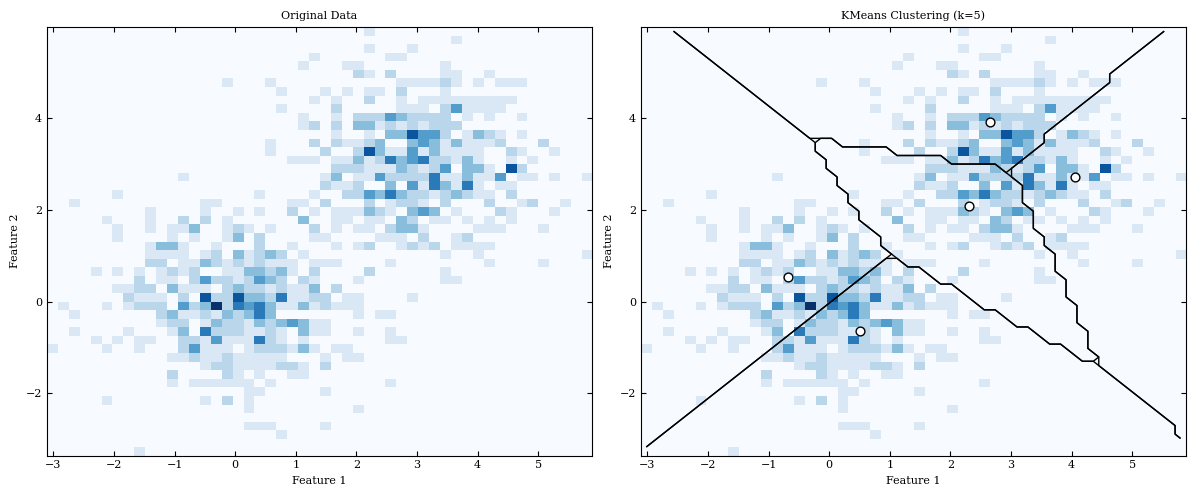

Number of clusters: 5


In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)
labels = kmeans.predict(X_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

H1, xedges1, yedges1 = np.histogram2d(X[:, 0], X[:, 1], 50)
ax1.imshow(H1.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]],
          cmap='Blues')
ax1.set_title('Original Data')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

H2, xedges2, yedges2 = np.histogram2d(X[:, 0], X[:, 1], 50)
ax2.imshow(H2.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]],
          cmap='Blues')
ax2.scatter(centers_original[:, 0], centers_original[:, 1],
           s=40, c='w', edgecolors='k')

x_centers = 0.5 * (xedges2[1:] + xedges2[:-1])
y_centers = 0.5 * (yedges2[1:] + yedges2[:-1])
Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T
H = kmeans.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0
    ax2.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

ax2.set_title('KMeans Clustering (k=5)')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

ax1.set_xlim(xedges1[0], xedges1[-1])
ax1.set_ylim(yedges1[0], yedges1[-1])
ax2.set_xlim(xedges2[0], xedges2[-1])
ax2.set_ylim(yedges2[0], yedges2[-1])

plt.tight_layout()
plt.show()

print("Number of clusters:", n_clusters)